In [17]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt; import xarray as xr;
import matplotlib.ticker as mticker
import os, sys, fsspec, importlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta
from scipy.signal import detrend, windows

sys.path.append( '/home/noelgb/repositories/modview/modview')
import viztools

sys.path.append( '/home/noelgb/repositories/slab/')
import models
importlib.reload( models )

fs = fsspec.filesystem('local')


In [2]:
front_surf = xr.open_dataset( 'front_surf_sup.nc' ).rename({'valid_time':'time'})

In [3]:

world = models.double_decker( front_surf )

In [24]:
world.ERA5['G'].dims

('time', 'latitude', 'longitude')

In [88]:
time_dim = 'time'; lat_dim = 'latitude'; lon_dim = 'longitude';

def detrender( data ):
    # Step 1: Detrend and remove mean
    data_detrended = detrend(data, axis=data.dims.index(time_dim), type='linear')
    data_detrended = data_detrended - data_detrended.mean( 0 )

    # Step 2: Apply a window function
    #window = windows.hanning(data_detrended.sizes[time_dim])
    #data_windowed = data_detrended * window
    return data_detrended

def get_spectra( data_windowed, data ):

    # Step 3: Compute the 2-D spatial Fourier transform
    fft_spatial = np.fft.fft2(data_windowed, axes=(data.dims.index(lat_dim), 
                                                   data.dims.index(lon_dim)))

    # Step 4: Compute the 1-D temporal Fourier transform
    fft_temporal = np.fft.fft(fft_spatial, axis=data.dims.index(time_dim))

    # Step 5: Compute the power spectrum
    power_spectrum = np.abs(fft_temporal) ** 2
    return power_spectrum

def organize_spectrum( data, power_spectrum ):
        # Step 6: Create output xarray.DataArray
    # Compute wavenumbers and frequencies
    lat_spacing = np.diff(data[lat_dim]).mean()
    lon_spacing = np.diff(data[lon_dim]).mean()
    time_spacing = np.diff(data[time_dim]).mean() / np.timedelta64(1, 'h')  # Convert to seconds

    k_lat = np.fft.fftfreq(data.sizes[lat_dim], d=lat_spacing)
    k_lon = np.fft.fftfreq(data.sizes[lon_dim], d=lon_spacing)
    freq = np.fft.fftfreq(data.sizes[time_dim], d=time_spacing)

    # Create output DataArray
    k_freq_spectrum = xr.DataArray(
        power_spectrum,
        dims=[time_dim, lat_dim, lon_dim],
        coords={
            lat_dim: k_lat,
            lon_dim: k_lon,
            time_dim: freq
        }
    )
    return k_freq_spectrum

def spectrum_whole( data ):
    data_w = detrender( data )
    spec = get_spectra( data_w, data )
    spec = organize_spectrum( data, spec )
    
    #spec['longitude'] = 2 * np.pi / spec['longitude'] * 110 * np.cos( 40/180 * np.pi ); # change to wavelengths
    #spec['latitude'] = 2 * np.pi / spec['latitude'] * 110
    spec = spec.sortby('time').sortby('latitude').sortby('longitude')
    #spec = spec.isel( {'longitude':range(len(spec['longitude'])-1), 
    #                   'latitude':range(1, len(spec['latitude'])) } )
    return spec 

In [89]:
cake = spectrum_whole( world.ERA5['G'] )

[Text(-1.2, 0, '-91'),
 Text(-0.8999999999999999, 0, '-122'),
 Text(-0.5999999999999999, 0, '-183'),
 Text(-0.2999999999999998, 0, '-366'),
 Text(2.220446049250313e-16, 0, '495395959010754560'),
 Text(0.30000000000000027, 0, '366'),
 Text(0.6000000000000003, 0, '183'),
 Text(0.9000000000000006, 0, '122'),
 Text(1.2000000000000004, 0, '91')]

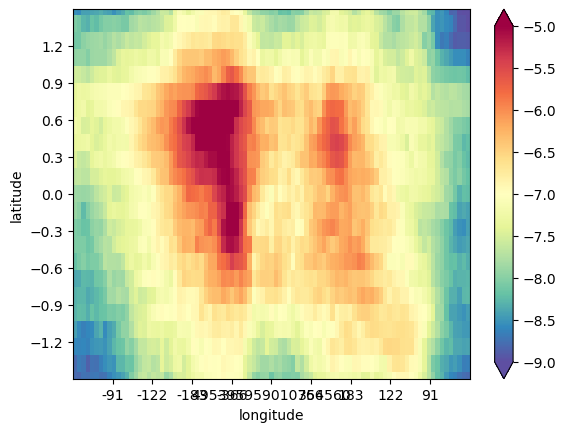

In [98]:
np.log10( cake.sel( time = slice(2 * np.pi / 21, 2*np.pi/15) ).mean('time')).plot( \
             cmap = 'Spectral_r', vmin = -9, vmax = -5 )
plt.xlim( [-1.5,1.5] ); plt.ylim([-1.5,1.5]);
tpos = np.arange( -1.2,1.21, 0.3)
plt.xticks( tpos );
plt.yticks( tpos );
ax = plt.gca()
ax.set_xticklabels( [ str( int( 1 / tp * 110 ) ) for tp in tpos ] )


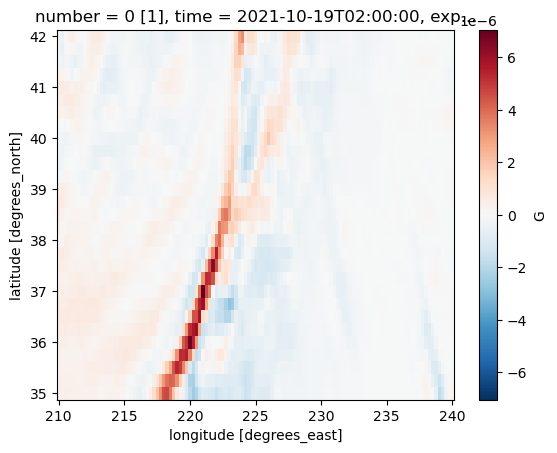

In [100]:
np.real( world.ERA5['G'].isel( time = 50 ) ).plot()

In [80]:
import numpy as np
import xarray as xr


def compute_wavenumber_frequency_spectrum(data, lat_dim='lat', lon_dim='lon', time_dim='time'):
    """
    Compute the wavenumber-frequency spectrum for a 3-D xarray dataset.

    Parameters:
        data (xarray.DataArray): Input data with dimensions (lat, lon, time).
        lat_dim (str): Name of the latitude dimension.
        lon_dim (str): Name of the longitude dimension.
        time_dim (str): Name of the time dimension.

    Returns:
        k_freq_spectrum (xarray.DataArray): Wavenumber-frequency spectrum.
    """


    # Step 3: Compute the 2-D spatial Fourier transform
    fft_spatial = np.fft.fft2(data_windowed, axes=(data.dims.index(lat_dim), data.dims.index(lon_dim)))

    # Step 4: Compute the 1-D temporal Fourier transform
    fft_temporal = np.fft.fft(fft_spatial, axis=data.dims.index(time_dim))

    # Step 5: Compute the power spectrum
    power_spectrum = np.abs(fft_temporal) ** 2

    # Step 6: Create output xarray.DataArray
    # Compute wavenumbers and frequencies
    lat_spacing = np.diff(data[lat_dim]).mean()
    lon_spacing = np.diff(data[lon_dim]).mean()
    time_spacing = np.diff(data[time_dim]).mean() / np.timedelta64(1, 's')  # Convert to seconds

    k_lat = np.fft.fftfreq(data.sizes[lat_dim], d=lat_spacing)
    k_lon = np.fft.fftfreq(data.sizes[lon_dim], d=lon_spacing)
    freq = np.fft.fftfreq(data.sizes[time_dim], d=time_spacing)

    # Create output DataArray
    k_freq_spectrum = xr.DataArray(
        power_spectrum,
        dims=[lat_dim, lon_dim, time_dim],
        coords={
            lat_dim: k_lat,
            lon_dim: k_lon,
            time_dim: freq
        }
    )

    return k_freq_spectrum